In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfaidx import Fasta
import logomaker

# plotting modules
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
samples_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/samples.h5"
motif_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/homer/motif_features.csv.gz"

linear_loc_arr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/linear/locations.npy"
linear_seq_arr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/linear/seq_attr.npy"
linear_pred_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/linear/homer_linear.csv.gz"

nlinear_loc_arr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/non_linear/locations.npy"
nlinear_seq_arr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/non_linear/seq_attr.npy"
nlinear_pred_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/non_linear/resnet_mlp.csv.gz"

genome_fasta = "/data5/deepro/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"

In [4]:
def read_pred_files(pred_file, seq_arr_file, loc_arr_file):
    pred_df = pd.read_csv(pred_file, header=None, names=["ypred", "ytarget", "chrm", "start", "end"])
    seq_arr = np.load(seq_arr_file)
    loc_arr = np.load(loc_arr_file)
    return pred_df, seq_arr, loc_arr

In [5]:
linear_pred_df, linear_seq_arr, linear_loc_arr = read_pred_files(linear_pred_file, linear_seq_arr_file, linear_loc_arr_file)
nlinear_pred_df, nlinear_seq_arr, nlinear_loc_arr = read_pred_files(nlinear_pred_file, nlinear_seq_arr_file, nlinear_loc_arr_file)
samples_df = pd.read_hdf(samples_file)
homer_df = pd.read_csv(motif_file, nrows=0, index_col=0)
features = np.array(homer_df.columns)
genome = Fasta(genome_fasta, as_raw=True)

# Compare predictions

In [6]:
def compare_top_preds():
    # merge data frames
    df = nlinear_pred_df.merge(linear_pred_df, on=["chrm", "start", "end", "ytarget"], suffixes=("_nonlinear", "_linear"))
    # get top predictions made by non linear and linear
    top_pred_nl = df.loc[(df.ytarget==1)&(df.ypred_nonlinear>0.99)]
    top_pred_l = df.loc[(df.ytarget==1)&(df.ypred_linear>0.99)]
    # get the most incorrect predictions for each
    top_incorrect_pred_nl = df.loc[(df.ytarget==0)&(df.ypred_nonlinear>0.99)]
    top_incorrect_pred_l = df.loc[(df.ytarget==0)&(df.ypred_linear>0.99)]
    return df, top_pred_nl, top_pred_l, top_incorrect_pred_nl, top_incorrect_pred_l

def get_top_n_features(seq_arr, features, n=5, lowest=False):
    top_ind = seq_arr.argsort()
    if lowest:
        top_ind = top_ind[::-1]
    top_ind = top_ind[-n:]
    return features[top_ind], seq_arr[top_ind]

def create_seq_attr_df(seq, seq_attr):
    data_arr = np.zeros((len(seq), 4))
    nts = ["A", "T", "G", "C"]
    seq_idx = dict(zip(nts, range(len(nts))))
    for i, (s, sq) in enumerate(zip(seq, seq_attr)):
        data_arr[i, seq_idx[s]] = sq
    data_df = pd.DataFrame(data_arr, columns=nts)
    return data_df

def get_complement(seq):
    complement_dict = {
        "A": "T",
        "G": "C",
        "T": "A",
        "C": "G"
        }    
    rev_comp_seq = "".join([complement_dict[s] for s in seq])
    return rev_comp_seq

def get_seq_info(df, idx, genome, seq_attr_arr, reverse=False):
    chrm, start, end = df.iloc[idx].loc[["chrm", "start", "end"]].values
    seq = list(genome.get_seq(chrm, start, end))
    if reverse:
        seq = get_complement(seq)
    seq_attr = seq_attr_arr[idx]
    return seq, seq_attr, (chrm, start, end)

def create_seqattr_figure(seq, seq_attr, nrows=5, figsize=(15, 10)):
    seq_df = create_seq_attr_df(seq, seq_attr)
    bp_per_row=len(seq)//nrows
    fig, ax = plt.subplots(nrows, 1, figsize=figsize, sharey=True)
    start = 0
    for row in range(nrows):
        # create Logo object
        ax_row = ax[row] if nrows>1 else ax
        nn_logo = logomaker.Logo(seq_df.iloc[start:start+bp_per_row], ax=ax_row,)
        nn_logo.ax.set_xticks([])
        start += bp_per_row
        ax_row.spines[['right', 'top', "bottom"]].set_visible(False)
        ax_row.xaxis.set_visible(False)
        # ax[row].set_yticks([])
        ax_row.set_ylim(seq_attr.min(), seq_attr.max())
    return fig, ax

In [7]:
df, top_pred_nl, top_pred_l, top_incorrect_pred_nl, top_incorrect_pred_l = compare_top_preds()

In [8]:
# fraction of top non linear model correct peak predictions incorrectly predicted by linear model
len(top_pred_nl.loc[top_pred_nl.ypred_linear<0.5])/len(top_pred_nl), len(top_pred_nl.loc[top_pred_nl.ypred_linear<0.5]), len(top_pred_nl)

(0.06976744186046512, 3, 43)

In [9]:
# fraction of top non linear model incorrect not peak predictions correctly predicted not peak by linear model
len(top_incorrect_pred_nl.loc[top_incorrect_pred_nl.ypred_linear<0.5])/len(top_incorrect_pred_nl), len(top_incorrect_pred_nl.loc[top_incorrect_pred_nl.ypred_linear>0.5]), len(top_incorrect_pred_nl)

(0.14285714285714285, 6, 7)

In [10]:
# fraction of top linear model correct peak predictions incorrectly predicted by non linear model
len(top_pred_l.loc[top_pred_l.ypred_nonlinear<0.5])/len(top_pred_l), len(top_pred_l.loc[top_pred_l.ypred_nonlinear<0.5]), len(top_pred_l)

(0.42857142857142855, 6, 14)

In [11]:
# fraction of top linear model incorrect not peak predictions correctly predicted not peak by non linear model
len(top_incorrect_pred_l.loc[top_incorrect_pred_l.ypred_nonlinear<0.5])/len(top_incorrect_pred_l), len(top_incorrect_pred_l.loc[top_incorrect_pred_l.ypred_nonlinear<0.5]), len(top_incorrect_pred_l)

(0.9807692307692307, 51, 52)

# Examples

1. index 24: both linear and non linear models learnt the ATF4 motif, chr18 63186581 63187081, Region shown - 63186660 to 63186730
2. index 59: non-linear model predicted it, linear model did not, chr6 149079598 149080098, Regions shown - 149079918-149080018

## ATF4 motif learnt

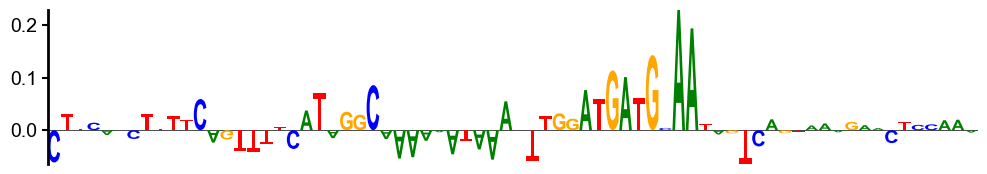

In [13]:
s, sa, (chrm, start, end) = get_seq_info(df, 24, genome, nlinear_seq_arr) 
fig, ax = create_seqattr_figure(s[80:150], sa[80:150], nrows=1, figsize=(12, 2))
save_file = "../data/figures/non_linear/atf4_motif_learnt.pdf"
save_pdf(save_file, fig)

In [14]:
get_top_n_features(linear_seq_arr[24], features, n=5, lowest=False)

(array(['MEF2B_HUMAN.H11MO.0.A|-', 'SRY_HUMAN.H11MO.0.B|+',
        'SOX2_HUMAN.H11MO.0.A|+', 'CEBPB_HUMAN.H11MO.0.A|+',
        'ATF4_HUMAN.H11MO.0.A|+'], dtype=object),
 array([0.12113363, 0.1248991 , 0.1579762 , 0.19703167, 0.43236878]))

## P53 motif learnt

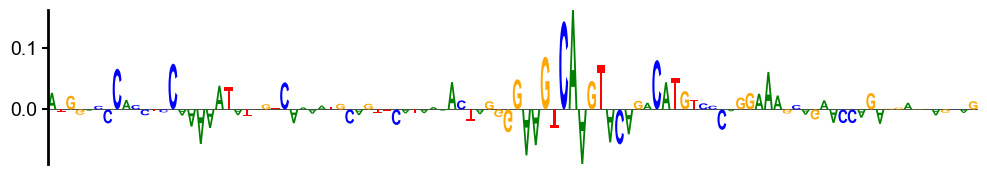

In [15]:
s, sa, (chrm, start, end) = get_seq_info(df, 59, genome, nlinear_seq_arr) 
fig, ax = create_seqattr_figure(s[320:420], sa[320:420], nrows=1, figsize=(12, 2))
save_file = "../data/figures/non_linear/p53_motif_learnt.pdf"
save_pdf(save_file, fig)

In [16]:
get_top_n_features(linear_seq_arr[59], features, n=5, lowest=False)

(array(['P63_HUMAN.H11MO.0.A|-', 'ELF3_HUMAN.H11MO.0.A|-',
        'P63_HUMAN.H11MO.0.A|+', 'P53_HUMAN.H11MO.0.A|-',
        'P53_HUMAN.H11MO.0.A|+'], dtype=object),
 array([0.07807649, 0.11143946, 0.18741657, 0.24088758, 0.33435656]))

# Archived code

In [61]:
# get top correct predictions from nlinear model
nlinear_top_pred = nlinear_pred_df.loc[(nlinear_pred_df.ytarget==1)&(nlinear_pred_df.ypred>0.99)].sort_values("ypred", ascending=False)

In [62]:
# get the same predictions from linear model
linear_pred_nlinear = linear_pred_df.iloc[nlinear_top_pred.index]

0.493854820728302
0.9999998807907104
chr6 149079598 149080098


(array(['P63_HUMAN.H11MO.0.A|-', 'ELF3_HUMAN.H11MO.0.A|-',
        'P63_HUMAN.H11MO.0.A|+', 'P53_HUMAN.H11MO.0.A|-',
        'P53_HUMAN.H11MO.0.A|+'], dtype=object),
 array([0.07807649, 0.11143946, 0.18741657, 0.24088758, 0.33435656]))

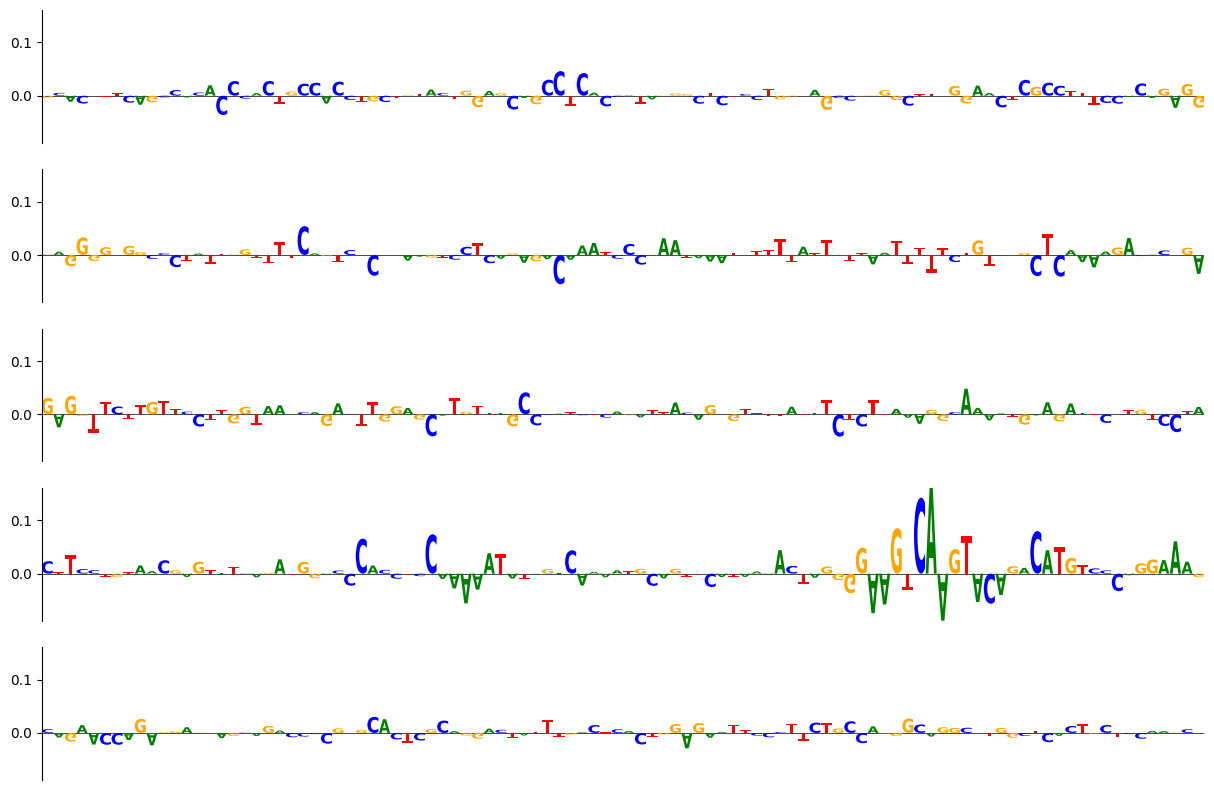

In [63]:
pos_idx=16  # 8,26:ATF4; 13,10,11:p53; 16:p53 flanking as well, non linear predicted it
reverse=False
lpred = linear_pred_nlinear.iloc[pos_idx]
print(lpred.ypred)
nlpred = nlinear_top_pred.iloc[pos_idx]
print(nlpred.ypred)
chrm, start, end = lpred.loc[["chrm", "start", "end"]].values
print(chrm, start, end)
seq = list(genome.get_seq(chrm, start, end))
if reverse:
    seq = get_complement(seq)
seq_attr = nlinear_seq_arr[nlinear_top_pred.index[pos_idx]]
seq_df = create_seq_attr_df(seq, seq_attr)

# make Figure and Axes objects
nrows=5
bp_per_row=len(seq)//nrows
fig, ax = plt.subplots(nrows, 1, figsize=(15, 10), sharey=True)

start = 0
for row in range(nrows):
    # create Logo object
    nn_logo = logomaker.Logo(seq_df.iloc[start:start+bp_per_row], ax=ax[row],)
    nn_logo.ax.set_xticks([])
    start += bp_per_row

    ax[row].spines[['right', 'top', "bottom"]].set_visible(False)
    ax[row].xaxis.set_visible(False)
    # ax[row].set_yticks([])
    ax[row].set_ylim(seq_attr.min(), seq_attr.max())

get_top_n_features(linear_seq_arr[linear_pred_nlinear.index[pos_idx]], features, n=5)

# Linear incorrect predictions, False positive case study

In [123]:
# get most incorrect predictions from linear model
linear_top_pred = linear_pred_df.loc[(linear_pred_df.ytarget==0)&(linear_pred_df.ypred>0.99)].sort_values("ypred", ascending=False)

In [125]:
# get the same predictions from nlinear model
linear_pred_nlinear = nlinear_pred_df.iloc[linear_top_pred.index]

0.99481862783432
4.857060957874637e-07
chr10 132516620 132517120


(array(['P53_HUMAN.H11MO.0.A|+', 'P53_HUMAN.H11MO.0.A|-',
        'P63_HUMAN.H11MO.0.A|+', 'MITF_HUMAN.H11MO.0.A|+',
        'KLF5_HUMAN.H11MO.0.A|-'], dtype=object),
 array([0.35822259, 0.29962437, 0.17872316, 0.12524376, 0.10552113]))

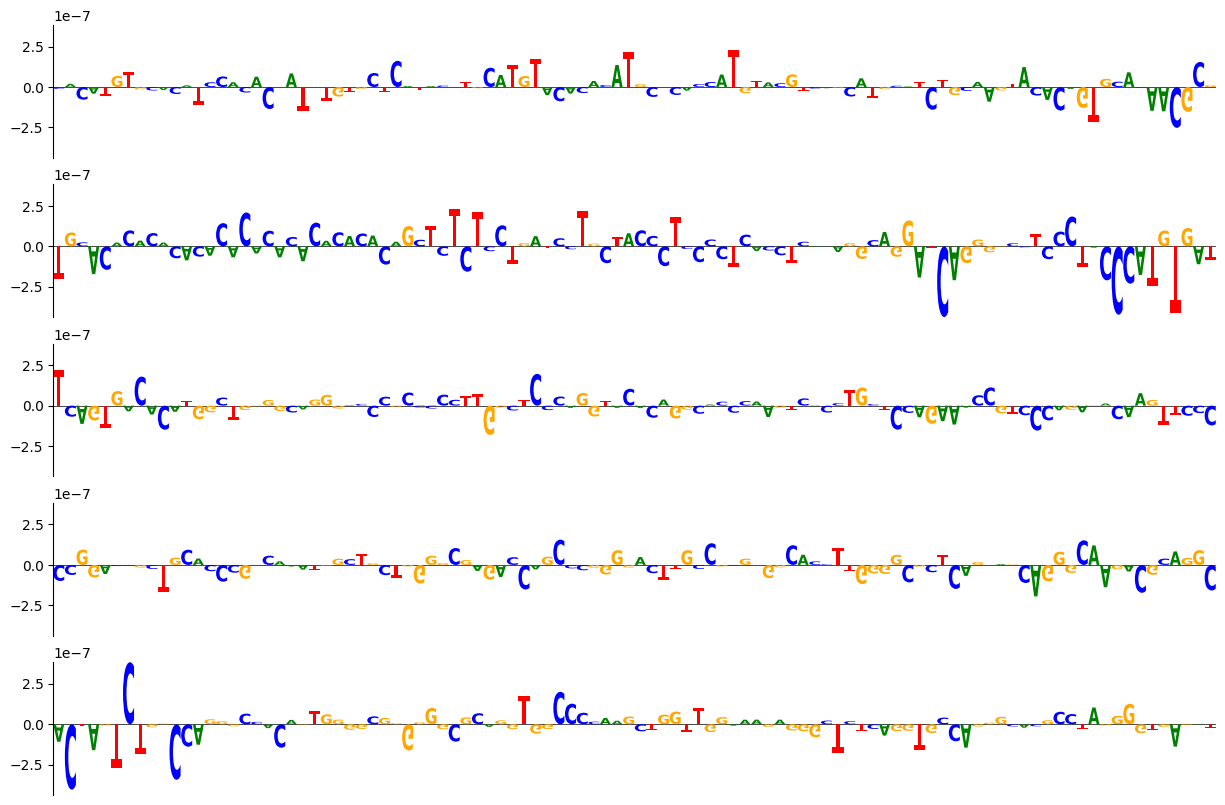

In [155]:
pos_idx=25  # 
reverse=False
lpred = linear_top_pred.iloc[pos_idx]
print(lpred.ypred)
nlpred = linear_pred_nlinear.iloc[pos_idx]
print(nlpred.ypred)
chrm, start, end = lpred.loc[["chrm", "start", "end"]].values
print(chrm, start, end)
seq = list(genome.get_seq(chrm, start, end))
if reverse:
    seq = get_complement(seq)
seq_attr = nlinear_seq_arr[linear_top_pred.index[pos_idx]]
seq_df = create_seq_attr_df(seq, seq_attr)

# make Figure and Axes objects
nrows=5
bp_per_row=len(seq)//nrows
fig, ax = plt.subplots(nrows, 1, figsize=(15, 10), sharey=True)

start = 0
for row in range(nrows):
    # create Logo object
    nn_logo = logomaker.Logo(seq_df.iloc[start:start+bp_per_row], ax=ax[row],)
    nn_logo.ax.set_xticks([])
    start += bp_per_row

    ax[row].spines[['right', 'top', "bottom"]].set_visible(False)
    ax[row].xaxis.set_visible(False)
    # ax[row].set_yticks([])
    ax[row].set_ylim(seq_attr.min(), seq_attr.max())

get_top_n_features(linear_seq_arr[linear_top_pred.index[pos_idx]], features, n=5)

In [126]:
linear_pred_nlinear

,ypred,ytarget,chrm,start,end
20072,1.877982e-07,0,chr14,65005604,65006104
23304,1.209096e-11,0,chr19,18364662,18365162
23255,1.327166e-09,0,chr2,177169964,177170464
21318,1.050642e-10,0,chr2,128305317,128305817
23299,1.850248e-09,0,chr5,174328432,174328932
23137,1.577736e-09,0,chr13,113837841,113838341
16638,2.916639e-09,0,chr7,111959089,111959589
21995,1.279697e-04,0,chr22,41217669,41218169
18921,4.229087e-11,0,chr5,59133965,59134465
12351,7.558446e-10,0,chr19,48418495,48418995
